In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
import random
from models import GCN

import matplotlib.pyplot as plt

from sklearn import metrics
from utils import get_plot

In [2]:
from data_process import generate_data, load_data
from train_func import test, train, Block_matrix_train, Lhop_Block_matrix_train, Communicate_train, ADMM_communication_train, Block_matrix_train_batch

In [3]:
def setdiff1d(t1, t2):
    
    combined = torch.cat((t1, t2))
    uniques, counts = combined.unique(return_counts=True)
    difference = uniques[counts == 1]
    #intersection = uniques[counts > 1]
    return difference
    

In [4]:
def intersect1d(t1, t2):
    
    combined = torch.cat((t1, t2))
    uniques, counts = combined.unique(return_counts=True)
    #difference = uniques[counts == 1]
    intersection = uniques[counts > 1]
    return intersection

In [5]:
args_no_cuda = False
args_cuda = not args_no_cuda and torch.cuda.is_available()
device = 'cuda:3' if args_cuda else 'cpu'

def get_graph(dataset_name, iid_percent, K_over_class_num):
    
        if dataset_name=='simulate':
            

            number_of_nodes=200
            class_num=3
            link_inclass_prob=10/number_of_nodes  #when calculation , remove the link in itself
            #EGCN good when network is dense 20/number_of_nodes  #fails when network is sparse. 20/number_of_nodes/5
            link_outclass_prob=link_inclass_prob/20
            features, adj, labels, idx_train, idx_val, idx_test =generate_data(number_of_nodes,  class_num, link_inclass_prob, link_outclass_prob)               
        else:
            #'cora', 'citeseer', 'pubmed' #other dataset twitter, 
            

            features, adj, labels, idx_train, idx_val, idx_test = load_data(dataset_name)
            class_num = labels.max().item() + 1


        #client num
        K = K_over_class_num * class_num
        
        
        split_data_indexes=[]
        
        nclass=labels.max().item() + 1
        split_data_indexes = []
        non_iid_percent = 1 - float(iid_percent)
        iid_indexes = [] #random assign
        shuffle_labels = [] #make train data points split into different devices
        for i in range(K):
            current = torch.nonzero(labels == i).reshape(-1)
            current = current[np.random.permutation(len(current))] #shuffle
            
            if args_cuda:
                current = current.to(device)
            
            shuffle_labels.append(current)

        average_device_of_class = K // nclass
        if K % nclass != 0: #for non-iid
            average_device_of_class += 1
        for i in range(K):  
            label_i= i // average_device_of_class    
            labels_class = shuffle_labels[label_i]

            average_num= int(len(labels_class)//average_device_of_class * non_iid_percent)
            split_data_indexes.append((labels_class[average_num * (i % average_device_of_class):average_num * (i % average_device_of_class + 1)]))
           
        if args_cuda:
            iid_indexes = setdiff1d(torch.tensor(range(len(labels))).to(device), torch.cat(split_data_indexes))
        else:
            iid_indexes = setdiff1d(torch.tensor(range(len(labels))), torch.cat(split_data_indexes))
        
        
        for i in range(K):  #for iid
            label_i= i // average_device_of_class
            labels_class = shuffle_labels[label_i]

            average_num= int(len(labels_class)//average_device_of_class * (1 - non_iid_percent))
            split_data_indexes[i] = list(split_data_indexes[i]) + list(iid_indexes[:average_num])
                    
            iid_indexes = iid_indexes[average_num:]
        
        
        #get train indexes in each device, only part of nodes in each device have labels in the train process
        split_train_ids = []
        for i in range(K):
            if args_cuda:
                split_data_indexes[i] = torch.tensor(split_data_indexes[i]).to(device)
            else:
                split_data_indexes[i] = torch.tensor(split_data_indexes[i])
                
            split_data_indexes[i] = split_data_indexes[i].sort()[0]

        one_hot_labels = F.one_hot(labels).float()
        
        return features, adj, labels, one_hot_labels, split_data_indexes, K


In [6]:
import numpy as np
import torch_geometric
np.random.seed(42)
torch.manual_seed(42)
dataset_name='cora'

List_one_hop_count = []
List_two_hop_count = []
List_BDS_one_local_update = []


for percent in range(0, 11, 1):
    length_current_index = []
    length_neighbor1 = []
    length_neighbor2 = []
    
    for time in range(1):
        iid_percent = percent / 10
        K_over_class_num = 1
        features, adj, labels, one_hot_labels, split_data_indexes, K = get_graph(dataset_name, iid_percent, K_over_class_num)
        if dataset_name=='simulate':
                feature = one_hot_labels
        
        row, col, edge_attr = adj.t().coo()
        edge_index = torch.stack([row, col], dim=0)
        
        one_hop_count = 0
        two_hop_count = 0
        BDS_one_local_update = 0
        for i in range(len(split_data_indexes)):
                current_index = split_data_indexes[i]
                
                neighbor1 = torch_geometric.utils.k_hop_subgraph(current_index,1,edge_index)[0]
                neighbor2 = torch_geometric.utils.k_hop_subgraph(current_index,1,edge_index)[0]

                #neighbor1 = get_K_hop_neighbors(adj, current_index, 1)

                #neighbor2 = get_K_hop_neighbors(adj, current_index, 2)
                #print(current_index)
                #1-hop communication
                for node in current_index:
                    communicate_client = set()
                    #print(node, adj[node].nonzero())
                    
                    for neighbor in adj[int(node)].coo()[1].to(device):
                        #print(neighbor)
                        if neighbor in current_index: #skip inside nodes
                            continue
                        for j in range(len(split_data_indexes)):
                            if neighbor in split_data_indexes[j]:
                                communicate_client.add(j)
                                break
                    #print(i, len(communicate_client))
                    #print(len(communicate_client))
                    one_hop_count += len(communicate_client)
                    two_hop_count += len(communicate_client)
                
                #2hop, since we have done 1-hop communication, we only needs to know the accumulation of features of neighbors
                two_hop_count += (len(neighbor1) - len(current_index))
                
                
                BDS_one_local_update += (len(neighbor1) - len(current_index))
        print(percent, one_hop_count, two_hop_count, BDS_one_local_update)
        List_one_hop_count.append(one_hop_count)
        List_two_hop_count.append(two_hop_count)
        List_BDS_one_local_update.append(BDS_one_local_update)
                    


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (11,) and (0,)

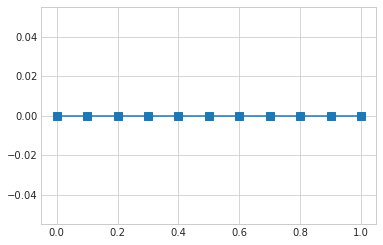

In [32]:

plt.style.use('seaborn-whitegrid')
X = np.array(range(0, 11, 1)) / 10
plt.plot(X, [0]*len(X), 's-', label = 'FedGCN(0-hop)', markersize=8)
plt.plot(X, List_one_hop_count, '+-', label = 'FedGCN(1-hop)', markersize=8)
plt.plot(X, List_two_hop_count, '*-', label = 'FedGCN(2-hop)', markersize=8)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('IID Degree', fontsize=25)
plt.ylabel('Communication Cost', fontsize=25)
plt.legend(fontsize=20, frameon=True, loc = 'best')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.savefig("cora_communication_cost_changeIID.png", format='png')
plt.savefig("cora_communication_cost_changeIID.pdf", format='pdf')

In [ ]:
bds_one = 5114
L = 2
T_iid =128
tau = 3
rho = 0.5
iid_total_bds = bds_one * L * T_iid * tau * rho

iid_total_dgcn = bds_one * L * T_iid * tau

iid_total_fedsage = len(labels) * T_iid * tau

plt.style.use('seaborn-whitegrid')
x = [0, 5114, 10228, iid_total_bds, 0]
y = [0.6915 , 0.8001 , 0.8038, 0.7365, 0.8013 ]
n = ["FedGCN(0-hop)", "FedGCN(1-hop)", "FedGCN", "BDS-GCN", "Centralized GCN"]

fig, ax = plt.subplots()
ax.scatter(x[4], y[4], s=120)
ax.scatter(x[0], y[0], s=120)
ax.scatter(x[3], y[3], s=120)
ax.scatter(x[1], y[1], s=120)
ax.scatter(x[2], y[2], s=120)



hfont = {'fontname':'Helvetica'}

for i, txt in enumerate(n):
        
    if '0-hop' in txt:
        ax.annotate(txt, (x[i], y[i] + 0.005), fontsize=20, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i], y[i] - 0.012), fontsize=20, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i] + 0.005), fontsize=20, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i] - 1900000, y[i] + 0.005), fontsize=20, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i], y[i] + 0.005), fontsize=20, **hfont)
        
        
#ax.set_xscale('log')
plt.ylim(0.68,0.82)
ax.set_xscale('symlog')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost, IID = 1.0', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')
plt.savefig("cora_comm_accuracy_IID.eps", format='eps')

In [ ]:
plt.style.use('seaborn-whitegrid')
T_non_iid = 64
bds_one = 1275


non_iid_total_bds =  bds_one* L * T_non_iid * tau * rho
x=[0, 1275, 2550, non_iid_total_bds, 0]
y=[0.8163 , 0.8097, 0.7966 , 0.8079, 0.8013 ]
n=["FedGCN(0-hop)", "FedGCN(1-hop)", "FedGCN", "BDS-GCN", "Centralized GCN"]

fig, ax = plt.subplots()
ax.scatter(x[4], y[4], s=120)
ax.scatter(x[0], y[0], s=120)
ax.scatter(x[3], y[3], s=120)
ax.scatter(x[1], y[1], s=120)
ax.scatter(x[2], y[2], s=120)

hfont = {'fontname':'Helvetica'}



for i, txt in enumerate(n):
    if '0-hop' in txt:
        ax.annotate(txt, (x[i], y[i] + 0.0016), fontsize=20, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i] - 1200, y[i] + 0.0016), fontsize=20, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i] + 0.0016), fontsize=20, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i] - 242000, y[i] - 0.0028), fontsize=20, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i], y[i] + 0.0016), fontsize=20, **hfont)
        
#ax.set_xscale('log')
plt.ylim([0.77,0.82])
ax.set_xscale('symlog')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost, IID = 0.0', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')
plt.savefig("cora_comm_accuracy_Non-IID.eps", format='eps')

In [ ]:
plt.style.use('seaborn-whitegrid')
T_partial_iid = 94
partial_iid_total_bds = 4304 * L * T_partial_iid * tau * rho
x=[0, 4300, 8604 , partial_iid_total_bds, 0]
y=[0.7475, 0.8030, 0.8010, 0.7791, 0.8013]
n=["FedGCN(0-hop)", "FedGCN(1-hop)", "FedGCN", "BDS-GCN", "Centralized GCN"]

fig, ax = plt.subplots()
ax.scatter(x[4], y[4], s=120)
ax.scatter(x[0], y[0], s=120)
ax.scatter(x[3], y[3], s=120)
ax.scatter(x[1], y[1], s=120)
ax.scatter(x[2], y[2], s=120)

hfont = {'fontname':'Helvetica'}



for i, txt in enumerate(n):
    if '0-hop' in txt:
        ax.annotate(txt, (x[i]+0.2, y[i] + 0.0015), fontsize=20, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i] - 4298.1, y[i] - 0.006), fontsize=20, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i] - 0.006), fontsize=20, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i] - 1150000, y[i] + 0.002), fontsize=20, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i] + 0.2, y[i] + 0.001), fontsize=20, **hfont)
#ax.set_xscale('log')
#plt.ylim(0.79,0.82)
ax.set_xscale('symlog')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost, IID = 0.5', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')
plt.savefig("cora_comm_accuracy_partial.eps", format='eps')




In [ ]:
bds_one = 5114
L = 2
T_iid =128
tau = 3
rho = 0.5
iid_total_bds = bds_one * L * T_iid * tau * rho

plt.style.use('seaborn-whitegrid')
x = [0, 5114, 10228, iid_total_bds, 0]
y = [0.6915 , 0.8001 , 0.8038, 0.7365, 0.8013 ]
n = ["FedGCN(0-hop) i.i.d.", "FedGCN(1-hop) i.i.d.", "FedGCN i.i.d.", "BDS-GCN i.i.d.", "Central"]

fig, ax = plt.subplots()
ax.scatter(x, y, s=60)

hfont = {'fontname':'Helvetica'}

for i, txt in enumerate(n):
    if '0-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)

        
T_non_iid = 64
bds_one = 1275


non_iid_total_bds =  bds_one* L * T_non_iid * tau * rho
x=[0, 1275, 2550, non_iid_total_bds]
y=[0.8163 , 0.8097, 0.7966 , 0.8079]
n=["FedGCN(0-hop) non-i.i.d.", "FedGCN(1-hop) non-i.i.d.", "FedGCN non-i.i.d.", "BDS-GCN non-i.i.d."]
ax.scatter(x, y, s=60)

for i, txt in enumerate(n):
    if '0-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
      

T_partial_iid = 94
partial_iid_total_bds = 4304 * L * T_partial_iid * tau * rho
x=[0, 4300, 8604 , partial_iid_total_bds]
y=[0.7475, 0.8030, 0.8010, 0.7791]
n=["FedGCN(0-hop) partial", "FedGCN(1-hop) partial", "FedGCN partial", "BDS-GCN partial"]
ax.scatter(x, y, s=60)

for i, txt in enumerate(n):
    if '0-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
     
        
#ax.set_xscale('log')
#plt.ylim(0.68,0.82)
ax.set_xscale('symlog')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')
plt.savefig("cora_comm_accuracy_IID.png", format='png')

In [ ]:
import numpy as np
np.random.seed(42)
torch.manual_seed(42)
dataset_name='simulate'
args_normalize = True

List_one_hop_count = []
List_two_hop_count = []
List_BDS_one_local_update = []


for percent in range(0, 11, 1):
    length_current_index = []
    length_neighbor1 = []
    length_neighbor2 = []
    
    for time in range(10):
        iid_percent = percent / 10
        K_over_class_num = 1
        features, adj, labels, one_hot_labels, split_data_indexes, K = get_graph(dataset_name, iid_percent, K_over_class_num)
        if dataset_name=='simulate':
                feature = one_hot_labels
        if args_normalize:
            adj = normalize(adj)
        one_hop_count = 0
        two_hop_count = 0
        BDS_one_local_update = 0
        for i in range(len(split_data_indexes)):
                current_index = split_data_indexes[i]

                neighbor1 = get_K_hop_neighbors(adj, current_index, 1)

                neighbor2 = get_K_hop_neighbors(adj, current_index, 2)
                #print(current_index)
                #1-hop communication
                for node in current_index:
                    communicate_client = set()
                    #print(node, adj[node].nonzero())
                    for neighbor in adj[node].nonzero():
                        #print(neighbor)
                        if neighbor in current_index: #skip inside nodes
                            continue
                        for j in range(len(split_data_indexes)):
                            if neighbor in split_data_indexes[j]:
                                communicate_client.add(j)
                                break
                    #print(i, len(communicate_client))
                    #print(len(communicate_client))
                    one_hop_count += len(communicate_client)
                    two_hop_count += len(communicate_client)
                
                #2hop, since we have done 1-hop communication, we only needs to know the accumulation of features of neighbors
                two_hop_count += (len(neighbor1) - len(current_index))
                
                
                BDS_one_local_update += (len(neighbor1) - len(current_index))
        print(percent, one_hop_count, two_hop_count, BDS_one_local_update)
        List_one_hop_count.append(one_hop_count)
        List_two_hop_count.append(two_hop_count)
        List_BDS_one_local_update.append(BDS_one_local_update)
                    
List_one_hop_count = [np.average(i) for i in np.array(List_one_hop_count).reshape(11,10)]
List_two_hop_count = [np.average(i) for i in np.array(List_two_hop_count).reshape(11,10)]
List_BDS_one_local_update = [np.average(i) for i in np.array(List_BDS_one_local_update).reshape(11,10)]

In [ ]:

plt.style.use('seaborn-whitegrid')
X = np.array(range(0, 11, 1)) / 10
plt.plot(X, [0]*len(X), 's-', label = 'FedGCN(0-hop)', markersize=8)
plt.plot(X, List_one_hop_count, '+-', label = 'FedGCN(1-hop)', markersize=8)
plt.plot(X, List_two_hop_count, '*-', label = 'FedGCN(2-hop)', markersize=8)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('IID Degree', fontsize=25)
plt.ylabel('Communication Cost', fontsize=25)
plt.legend(fontsize=20, frameon=True, loc = 'best')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.savefig("simulate_communication_cost_changeIID.png", format='png')
plt.savefig("simulate_communication_cost_changeIID.pdf", format='pdf')

In [ ]:
import numpy as np
import torch_geometric
np.random.seed(42)
torch.manual_seed(42)
dataset_name='ogbn-arxiv'

List_one_hop_count = []
List_two_hop_count = []
List_BDS_one_local_update = []


for percent in range(0, 11, 5):
    length_current_index = []
    length_neighbor1 = []
    length_neighbor2 = []
    
    for time in range(1):
        iid_percent = percent / 10
        K_over_class_num = 1
        features, adj, labels, one_hot_labels, split_data_indexes, K = get_graph(dataset_name, iid_percent, K_over_class_num)
        if dataset_name=='simulate':
                feature = one_hot_labels
        
        row, col, edge_attr = adj.t().coo()
        edge_index = torch.stack([row, col], dim=0)
        
        one_hop_count = 0
        two_hop_count = 0
        BDS_one_local_update = 0
        for i in range(len(split_data_indexes)):
                print(i)
                current_index = split_data_indexes[i]
                
                neighbor1 = torch_geometric.utils.k_hop_subgraph(current_index,1,edge_index)[0]
                neighbor2 = torch_geometric.utils.k_hop_subgraph(current_index,1,edge_index)[0]

                #neighbor1 = get_K_hop_neighbors(adj, current_index, 1)

                #neighbor2 = get_K_hop_neighbors(adj, current_index, 2)
                #print(current_index)
                #1-hop communication
                for node in current_index:
                    communicate_client = set()
                    #print(node, adj[node].nonzero())
                    
                    for neighbor in adj[int(node)].coo()[1].to(device):
                        #print(neighbor)
                        if neighbor in current_index: #skip inside nodes
                            continue
                        for j in range(len(split_data_indexes)):
                            if neighbor in split_data_indexes[j]:
                                communicate_client.add(j)
                                break
                    #print(i, len(communicate_client))
                    #print(len(communicate_client))
                    one_hop_count += len(communicate_client)
                    two_hop_count += len(communicate_client)
                
                #2hop, since we have done 1-hop communication, we only needs to know the accumulation of features of neighbors
                two_hop_count += (len(neighbor1) - len(current_index))
                
                
                BDS_one_local_update += (len(neighbor1) - len(current_index))
        print(percent, one_hop_count, two_hop_count, BDS_one_local_update)
        List_one_hop_count.append(one_hop_count)
        List_two_hop_count.append(two_hop_count)
        List_BDS_one_local_update.append(BDS_one_local_update)
                    


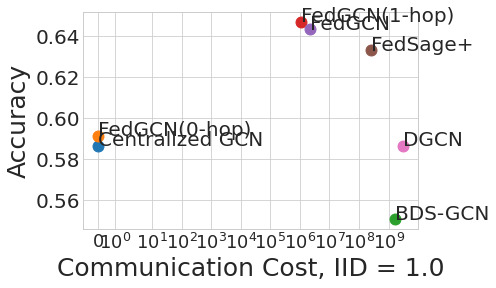

In [108]:
bds_one = 1075294
L = 2
tau = 3
rho = 0.5
iid_total_bds = bds_one * L * 499 * tau * rho #times convergence time

iid_total_dgcn = bds_one * L * 465 * tau

iid_total_fedsage = len(labels) * 499 * tau

plt.style.use('seaborn-whitegrid')
x = [0, 1075294, 2150588, iid_total_bds, 0, iid_total_fedsage, iid_total_dgcn]


y = [0.5914067620752393, 0.6471969690289547, 0.6435552185197269, 0.5505586074933646, 0.5865975351315761, 0.6331337571754829, 0.5865975351315761]

n = ["FedGCN(0-hop)", "FedGCN(1-hop)", "FedGCN", "BDS-GCN", "Centralized GCN", "FedSage+", "DGCN"]

fig, ax = plt.subplots()
ax.scatter(x[4], y[4], s=120)
ax.scatter(x[0], y[0], s=120)
ax.scatter(x[3], y[3], s=120)
ax.scatter(x[1], y[1], s=120)
ax.scatter(x[2], y[2], s=120)
ax.scatter(x[5], y[5], s=120)
ax.scatter(x[6], y[6], s=120)



hfont = {'fontname':'Helvetica'}


for i, txt in enumerate(n):
    
    if '0-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=20, **hfont)
    
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=20, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=20, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i], y[i] ), fontsize=20, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=20, **hfont)
    elif 'FedSage+' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=20, **hfont)
    elif 'DGCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=20, **hfont)
    
        
#ax.set_xscale('log')
#plt.ylim(0.68,0.82)
ax.set_xscale('symlog')

plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost, IID = 1.0', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')
plt.savefig("ogbn-arxiv_comm_accuracy_IID.pdf", format='pdf', bbox_inches = "tight")

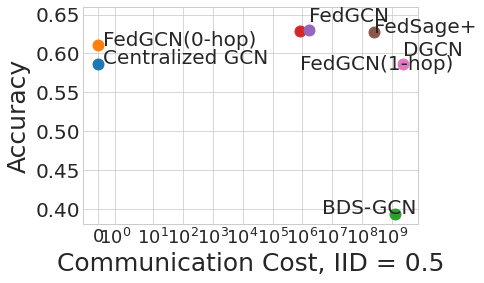

In [105]:
bds_one = 797997
L = 2
tau = 3
rho = 0.5


iid_total_bds = bds_one * L * 499 * tau * rho #times convergence time

iid_total_dgcn = bds_one * L * 465 * tau

iid_total_fedsage = len(labels) * 496 * tau

plt.style.use('seaborn-whitegrid')
x = [0, 797874, 1595871, iid_total_bds, 0, iid_total_fedsage, iid_total_dgcn]

y = [0.6102827279915114, 0.6289852772168679, 0.6306253876156969, 0.3935991605456453, 0.5865975351315761, 0.6270271382424953, 0.5865975351315761]

n = ["FedGCN(0-hop)", "FedGCN(1-hop)", "FedGCN", "BDS-GCN", "Centralized GCN", "FedSage+", "DGCN"]

fig, ax = plt.subplots()
ax.scatter(x[4], y[4], s=120)
ax.scatter(x[0], y[0], s=120)
ax.scatter(x[3], y[3], s=120)
ax.scatter(x[1], y[1], s=120)
ax.scatter(x[2], y[2], s=120)
ax.scatter(x[5], y[5], s=120)
ax.scatter(x[6], y[6], s=120)



hfont = {'fontname':'Helvetica'}

for i, txt in enumerate(n):
        
    if '0-hop' in txt:
        ax.annotate(txt, (x[i] + 0.3, y[i]), fontsize=20, **hfont)
    
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i], y[i] - 0.05), fontsize=20, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i] + 0.01), fontsize=20, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i] - 1.19 * 10** 9, y[i]), fontsize=20, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i]+0.3, y[i]), fontsize=20, **hfont)
    elif 'FedSage+' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=20, **hfont)
    elif 'DGCN' in txt:
        ax.annotate(txt, (x[i] - 1000000, y[i]+0.01), fontsize=20, **hfont)
    
        
        
#ax.set_xscale('log')
plt.ylim(0.38,0.66)
ax.set_xscale('symlog')

plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost, IID = 0.5', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')

fig = plt.gcf()
#fig.set_size_inches((8.5, 11), forward=False)

fig.savefig("ogbn-arxiv_comm_accuracy_partial.pdf", format='pdf', bbox_inches = "tight")

In [91]:
numpy.array(x)

array([0.00000000e+00, 7.97874000e+05, 1.59587100e+06, 1.19460151e+09,
       0.00000000e+00, 2.51982384e+08, 2.22641163e+09])

In [7]:
features, adj, labels, one_hot_labels, split_data_indexes, K = get_graph("ogbn-arxiv", 1.0, 40)


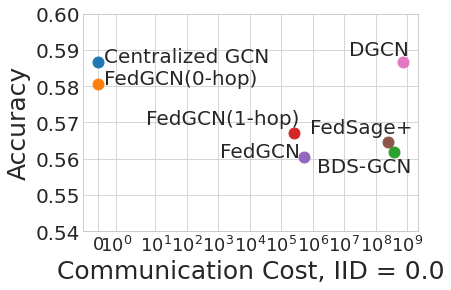

In [109]:
bds_one = 255945
L = 2
tau = 3
rho = 0.5
iid_total_bds = bds_one * L * 481 * tau * rho #times convergence time

iid_total_dgcn = bds_one * L * 465 * tau

iid_total_fedsage = len(labels) * 474 * tau

plt.style.use('seaborn-whitegrid')
x = [0, 255945, 511890, iid_total_bds, 0, iid_total_fedsage, iid_total_dgcn]

import numpy
x = numpy.array(x)# / 40

y = [0.5804991461432422, 0.5670079154431972, 0.5605278137837856, 0.5619385634631607, 0.5865975351315761, 0.5647099973252679, 0.5865975351315761]

n = ["FedGCN(0-hop)", "FedGCN(1-hop)", "FedGCN", "BDS-GCN", "Centralized GCN", "FedSage+", "DGCN"]

fig, ax = plt.subplots()
ax.scatter(x[4], y[4], s=120)
ax.scatter(x[0], y[0], s=120)
ax.scatter(x[3], y[3], s=120)
ax.scatter(x[1], y[1], s=120)
ax.scatter(x[2], y[2], s=120)
ax.scatter(x[5], y[5], s=120)
ax.scatter(x[6], y[6], s=120)



hfont = {'fontname':'Helvetica'}

for i, txt in enumerate(n):
    
    if '0-hop' in txt:
        ax.annotate(txt, (x[i] + 0.3, y[i]), fontsize=20, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i] - 2.5594 * 10**5, y[i] + 0.0026), fontsize=20, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i] - 5.108 * 10**5 , y[i]), fontsize=20, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i] - 3.68 * 10**8, y[i] - 0.0055), fontsize=20, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i]+0.3, y[i]), fontsize=20, **hfont)
    elif 'FedSage+' in txt:
        ax.annotate(txt, (x[i] - 2.4 * 10 ** 8, y[i] + 0.0025), fontsize=20, **hfont)
    elif 'DGCN' in txt:
        ax.annotate(txt, (x[i] - 7* 10**8, y[i]+0.002), fontsize=20, **hfont)
     
        
#ax.set_xscale('log')
plt.ylim(0.54,0.6)
ax.set_xscale('symlog')

plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost, IID = 0.0', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')

#plt.show()
plt.savefig("ogbn-arxiv_comm_accuracy_Non-IID.pdf", format="pdf", bbox_inches = "tight")